In [1]:
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import IPython
from IPython.display import display, clear_output
from matplotlib import rcParams 
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

import numpy as np
import matplotlib.pyplot as plt

from packages.Util import GD
from packages.data_generation import DG
from packages.Optimizers import k_Logistic, k_SVM, k_Perceptron, k_Regression
from packages.Kernels import Polynomial, Linear, RBF
from packages.Regularizers import Regularizer, L1, L2

from sklearn import svm
from sklearn import datasets

# Kernelized Perceptron
Both perceptron and SVM can be kernelized, i.e. the output of the feature space can be passed through the sign function. 

$$ \hat{y} = \text{sign}\left[\hat{f}(x)\right] =\text{sign} \left[ \sum_{i=1}^N \alpha_i K(x_i, x) \right] $$ and a perceptron loss applied to the difference between the predictor and the true value. 

The perceptron loss over a single data point can be posed as:

$$ l(\alpha;x_j, y_j) = \max \left\{0, -\sum_{j=1}^N y_j \alpha_i K(x_i, x_j) \right\} $$ 

The parameters are updated as follows: 
If $\hat{y}(x) \neq y(x)$, set $\alpha \gets \alpha + \eta_t$. 

In [3]:
N=200
def kernelized_perceptron(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True):
    if dataset == 'Blobs':
        X, Y = datasets.make_blobs(n_samples=N, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset == 'Circles':
        X, Y = datasets.make_circles(n_samples=N, factor=0.48, random_state=26, noise=noise)
    elif dataset == 'Moons' :
        X, Y = datasets.make_moons(n_samples=N, random_state=26, noise=noise)
    Y[np.where(Y==0)[0]] = -1
    
    if kernel == 'Linear':
        _kernel = Linear
    elif kernel == 'Polynomial':
        _kernel = Polynomial
    elif kernel == 'RBF':
        _kernel = RBF
    
    if regularizer:
        _regularizer = L2
    else:
        _regularizer = Regularizer
    
    opts = {'batchsize': bs,
           'iter': ite,
           'eta0':eta0,
           'learning rate': lrm}
    
    np.random.seed(1)
    alpha0 = np.random.randn(X.shape[0]) * 0
    optimizer = k_Perceptron(X, Y, kernel=_kernel, bw=bw, deg=deg, reg=reg, regularizer=_regularizer)
    alpha_hat = GD(alpha0, optimizer, opts)[-1]
    #print(alpha_hat)
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    min1, max1 = X[:,0].min()-0.5, X[:,0].max()+0.5
    min2, max2 = X[:,1].min()-0.5, X[:,1].max()+0.5
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    #grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = optimizer.predict(grid, alpha_hat)
    zz = Y1.reshape(xx.shape)
    c = ax1.contourf(xx, yy, zz, cmap='RdBu', alpha=0.46)
    #plt.colorbar(c)
    ax1.plot(X[np.where(Y==1)[0], 0 ], X[np.where(Y==1)[0], 1], 'bs', label='Positive data')
    ax1.plot(X[np.where(Y==-1)[0], 0 ], X[np.where(Y==-1)[0], 1], 'ro', label='Negtive data')
    ax1.legend(bbox_to_anchor=(1, 1))
    
d = ipywidgets.Dropdown(options=['Blobs', 'Circles', 'Moons'], value='Blobs', description='Dataset')


k = ipywidgets.Dropdown(options=['Linear', 'Polynomial', 'RBF'], value='Linear', description='Kernel')

reg = ipywidgets.FloatSlider(value=1e-2,min=1e-3,max=1,step=1e-3,description='Regularization:',
                           style={'description_width': 'initial'},continuous_update=False)

bw=ipywidgets.FloatSlider(value=0.01,min=0.001,max=3,step=0.01,description='Bandwidth:',
                                    style={'description_width': 'initial'},continuous_update=False)

deg=ipywidgets.IntSlider(value=2,min=1,max=10, step=1,description='Degree',style={'description_width': 'initial'})

noise=ipywidgets.FloatSlider(value=0.05,min=0.01,max=0.3,step=0.01,readout_format='.2f',description='Noise level:',
                                    style={'description_width': 'initial'},continuous_update=False)

bs = ipywidgets.IntSlider(value=20, min=1, max=200, step=1, description='Batch size')

ite = ipywidgets.IntSlider(value=50, min=20, max=500, step=20, description='Iterations')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

interact(kernelized_perceptron, dataset=d, kernel=k, bw=bw, deg=deg, 
         reg=reg, noise=noise, bs=bs, ite=ite, eta0=eta_widget, lrm=lrm_widget)

interactive(children=(Dropdown(description='Dataset', options=('Blobs', 'Circles', 'Moons'), value='Blobs'), D…

<function __main__.kernelized_perceptron(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True)>

# Kernelized SVM

In [6]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16
N=200
def kernelized_SVM(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True):
    if dataset == 'Blobs':
        X, Y = datasets.make_blobs(n_samples=N, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset == 'Circles':
        X, Y = datasets.make_circles(n_samples=N, factor=0.48, random_state=26, noise=noise)
    elif dataset == 'Moons' :
        X, Y = datasets.make_moons(n_samples=N, random_state=26, noise=noise)
    Y[np.where(Y==0)[0]] = -1
    
    if kernel == 'Linear':
        _kernel = Linear
    elif kernel == 'Polynomial':
        _kernel = Polynomial
    elif kernel == 'RBF':
        _kernel = RBF
    
    if regularizer:
        _regularizer = L2
    else:
        _regularizer = Regularizer
    
    opts = {'batchsize': bs,
           'iter': ite,
           'eta0':eta0,
           'learning rate': lrm}
    
    alpha0 = np.zeros(X.shape[0])
    #X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    optimizer = k_SVM(X, Y, kernel=_kernel, bw=bw, deg=deg, reg=reg, regularizer=_regularizer)
    alpha_hat = GD(alpha0, optimizer, opts)[-1]

    fig, ax1 = plt.subplots()
    min1, max1 = X[:,0].min()-0.5, X[:,0].max()+0.5
    min2, max2 = X[:,1].min()-0.5, X[:,1].max()+0.5
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    #grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = optimizer.predict(grid, alpha_hat)
    zz = Y1.reshape(xx.shape)
    c = ax1.contourf(xx, yy, zz, cmap='RdBu', alpha=0.46)
    #plt.colorbar(c)
    ax1.plot(X[np.where(Y==1)[0], 0 ], X[np.where(Y==1)[0], 1], 'bs', label='Positive data')
    ax1.plot(X[np.where(Y==-1)[0], 0 ], X[np.where(Y==-1)[0], 1], 'ro', label='Negtive data')
    ax1.legend(bbox_to_anchor=(1, 1))
    
d = ipywidgets.Dropdown(options=['Blobs', 'Circles', 'Moons'], value='Blobs', description='Dataset')


k = ipywidgets.Dropdown(options=['Linear', 'Polynomial', 'RBF'], value='Linear', description='Kernel')

reg = ipywidgets.FloatSlider(value=1e-2,min=1e-3,max=1,step=1e-3,description='Regularization:',
                           style={'description_width': 'initial'},continuous_update=False)

bw=ipywidgets.FloatSlider(value=0.01,min=0.001,max=3,step=0.01,description='Bandwidth:',
                                    style={'description_width': 'initial'},continuous_update=False)

deg=ipywidgets.IntSlider(value=2,min=1,max=10, step=1,description='Degree',style={'description_width': 'initial'})

noise=ipywidgets.FloatSlider(value=0.05,min=0.01,max=0.3,step=0.01,readout_format='.2f',description='Noise level:',
                                    style={'description_width': 'initial'},continuous_update=False)

bs = ipywidgets.IntSlider(value=20, min=1, max=200, step=1, description='Batch size')

ite = ipywidgets.IntSlider(value=10, min=10, max=500, step=20, description='Iterations')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.1, max=5., step=0.5, description='Learning rate')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

interact(kernelized_SVM, dataset=d, kernel=k, bw=bw, deg=deg, 
         reg=reg, noise=noise, bs=bs, ite=ite, eta0=eta_widget, lrm=lrm_widget)

interactive(children=(Dropdown(description='Dataset', options=('Blobs', 'Circles', 'Moons'), value='Blobs'), D…

<function __main__.kernelized_SVM(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True)>

# Kernelized Logistic

In [4]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16
N=200
def kernelized_Logistic(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True):
    if dataset == 'Blobs':
        X, Y = datasets.make_blobs(n_samples=N, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset == 'Circles':
        X, Y = datasets.make_circles(n_samples=N, factor=0.48, random_state=26, noise=noise)
    elif dataset == 'Moons' :
        X, Y = datasets.make_moons(n_samples=N, random_state=26, noise=noise)
    Y[np.where(Y==0)[0]] = -1
    
    if kernel == 'Linear':
        _kernel = Linear
    elif kernel == 'Polynomial':
        _kernel = Polynomial
    elif kernel == 'RBF':
        _kernel = RBF
    
    if regularizer:
        _regularizer = L2
    else:
        _regularizer = Regularizer
    
    opts = {'batchsize': bs,
           'iter': ite,
           'eta0':eta0,
           'learning rate': lrm}
    
    np.random.seed(1)
    alpha0 = np.random.randn(X.shape[0]) * 0
    optimizer = Logistic(X, Y, kernel=_kernel, bw=bw, deg=deg, reg=reg, regularizer=_regularizer)
    alpha_hat = GDnew(alpha0, optimizer, opts)[-1]
    
    fig, ax1 = plt.subplots()
    
    min1, max1 = X[:,0].min()-0.5, X[:,0].max()+0.5
    min2, max2 = X[:,1].min()-0.5, X[:,1].max()+0.5
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    #grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = optimizer.predict(grid, alpha_hat)
    zz = Y1.reshape(xx.shape)
    c = ax1.contourf(xx, yy, zz, cmap='jet', alpha=0.5)
    plt.colorbar(c)
    ax1.plot(X[np.where(Y==1)[0], 0 ], X[np.where(Y==1)[0], 1], 'bs', label='Positive data')
    ax1.plot(X[np.where(Y==-1)[0], 0 ], X[np.where(Y==-1)[0], 1], 'ro', label='Negtive data')
    ax1.legend(bbox_to_anchor=(1.6, 1) )
    #Y2 = [i for i in Y1 if i!=0 and i!=1]
    #print(len(Y2))
d = ipywidgets.Dropdown(options=['Blobs', 'Circles', 'Moons'], value='Blobs', description='Dataset')


k = ipywidgets.Dropdown(options=['Linear', 'Polynomial', 'RBF'], value='Linear', description='Kernel')

reg = ipywidgets.FloatSlider(value=1e-2,min=1e-3,max=1,step=1e-3,description='Regularization:',
                           style={'description_width': 'initial'},continuous_update=False)

bw=ipywidgets.FloatSlider(value=0.1,min=0.001,max=3,step=0.01,description='Bandwidth:',
                                    style={'description_width': 'initial'},continuous_update=False)

deg=ipywidgets.IntSlider(value=2,min=1,max=10, step=1,description='Degree',style={'description_width': 'initial'})

noise=ipywidgets.FloatSlider(value=0.05,min=0.01,max=0.3,step=0.01,readout_format='.2f',description='Noise level:',
                                    style={'description_width': 'initial'},continuous_update=False)

bs = ipywidgets.IntSlider(value=20, min=1, max=200, step=1, description='Batch size')

ite = ipywidgets.IntSlider(value=50, min=20, max=500, step=20, description='Iterations')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

interact(kernelized_Logistic, dataset=d, kernel=k, bw=bw, deg=deg, 
         reg=reg, noise=noise, bs=bs, ite=ite, eta0=eta_widget, lrm=lrm_widget)

interactive(children=(Dropdown(description='Dataset', options=('Blobs', 'Circles', 'Moons'), value='Blobs'), D…

<function __main__.kernelized_Logistic(dataset, kernel, bw, deg, reg, noise, bs, ite, eta0, lrm, regularizer=True)>

# Kernelized Regression

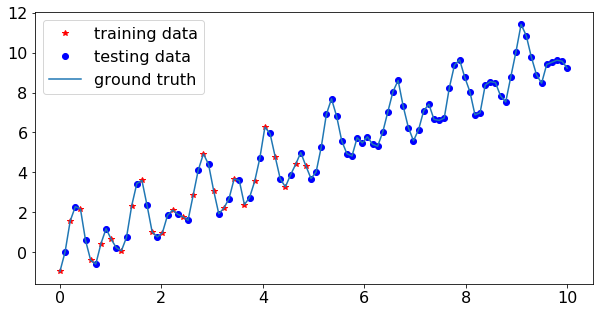

In [2]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

num_points = 100
xmin = 0
xmax = 10
noise = 0.2

X = np.reshape(np.linspace(xmin, xmax, num_points), [-1, 1])  # create 1-D input data
F = X + np.sin(X * 5) - np.cos(X * 10)  # true functional response
Y = F + noise * np.random.randn(num_points, 1)  # generate noisy labels

# Training Data
training_idx = np.arange(0, 50, 2)
Xtr = X[training_idx, :]
Ytr = Y[training_idx]

# Test Data
test_idx = np.setdiff1d(np.arange(0, num_points, 1), training_idx)
Xtest = X[test_idx, :]
Ytest = Y[test_idx]
fig, ax = plt.subplots()
ax.plot(Xtr, Ytr, 'r*',label='training data')
ax.plot(Xtest, Ytest,'bo', label='testing data')
ax.plot(X,Y, label='ground truth')
ax.legend()

In [3]:
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16
def kernelized_regression(kernel, bw, deg, reg, bs, ite, eta0, lrm, noise, regularizer=True, cf=True):    
    if kernel == 'Linear':
        _kernel = Linear
    elif kernel == 'Polynomial':
        _kernel = Polynomial
    elif kernel == 'RBF':
        _kernel = RBF
    
    if regularizer:
        _regularizer = L2
    else:
        _regularizer = Regularizer
    
    opts = {'batchsize': bs,
           'iter': ite,
           'eta0':eta0,
           'learning rate': lrm}
    N = 100
    dim = 1
    np.random.seed(26)
    x_full, y_full = DG(N, noise, dim).Gaussianbased_data1(0., 1.)
    X = x_full.reshape(-1,1)
    Y = y_full
    x_plt = np.linspace(-3, 3, 200)
    y_plt = 1 + x_plt + 0.3 * np.sin(10*x_plt)
    Xtest = x_plt.reshape(-1,1)
    
    alpha0 = np.random.randn(X.shape[0]) * 0
    optimizer = Regression(X, Y, kernel=_kernel, bw=bw, deg=deg, reg=reg, regularizer=_regularizer)
    alpha_hat = optimizer.closed() if cf else GDnew(alpha0, optimizer, opts)[-1]
    Yval = optimizer.predict(Xtest, alpha_hat)
    fig, ax1 = plt.subplots()
    #ax1.plot(Xtr, Ytr, 'r*',label='training data')
    ax1.plot(x_plt, Yval, label='kernel', lw=3)
    ax1.plot(x_full, y_full,'bo', label='training data')
    ax1.plot(x_plt, y_plt, label='ground truth')
    ax1.set_ylim(np.min(y_plt)-1,np.max(y_plt)+1)
    ax1.legend()

k = ipywidgets.Dropdown(options=['Linear', 'Polynomial', 'RBF'], value='Linear', description='Kernel')

reg = ipywidgets.FloatSlider(value=1e-2,min=1e-3,max=10,step=1e-3,description='Regularization:',
                           style={'description_width': 'initial'},continuous_update=False)

bw=ipywidgets.FloatSlider(value=0.1,min=0.001,max=3,step=0.01,description='Bandwidth:',
                                    style={'description_width': 'initial'},continuous_update=False)

deg=ipywidgets.IntSlider(value=2,min=1,max=10, step=1,description='Degree',style={'description_width': 'initial'})

bs = ipywidgets.IntSlider(value=20, min=1, max=200, step=1, description='Batch size')
noise = ipywidgets.FloatSlider(value=0.2, min=0.1, max=1., step=0.1, description='Data noise')
ite = ipywidgets.IntSlider(value=50, min=20, max=500, step=20, description='Iterations')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

interact(kernelized_regression, kernel=k, bw=bw, deg=deg, 
         reg=reg, bs=bs, ite=ite, eta0=eta_widget, lrm=lrm_widget, noise=noise)

interactive(children=(Dropdown(description='Kernel', options=('Linear', 'Polynomial', 'RBF'), value='Linear'),…

<function __main__.kernelized_regression(kernel, bw, deg, reg, bs, ite, eta0, lrm, noise, regularizer=True, cf=True)>